Using Colab cache for faster access to the 'creditcardfraud' dataset.
Dataset downloaded to: /kaggle/input/creditcardfraud
Class
0    284315
1       492
Name: count, dtype: int64


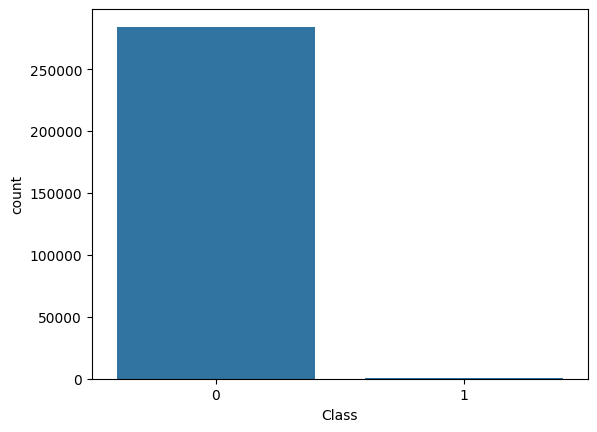

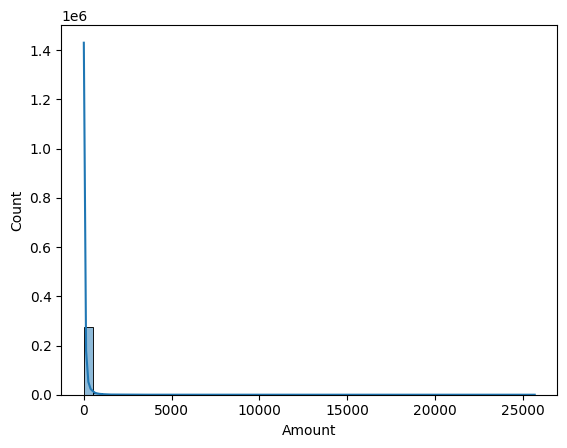

After SMOTE: [227451 227451]

===== Training XGBoost =====
XGBoost optimal threshold: 0.20502417
              precision    recall  f1-score   support

           0     0.9998    0.9996    0.9997     56864
           1     0.8000    0.8571    0.8276        98

    accuracy                         0.9994     56962
   macro avg     0.8999    0.9284    0.9136     56962
weighted avg     0.9994    0.9994    0.9994     56962

ROC-AUC: 0.9691087148140067


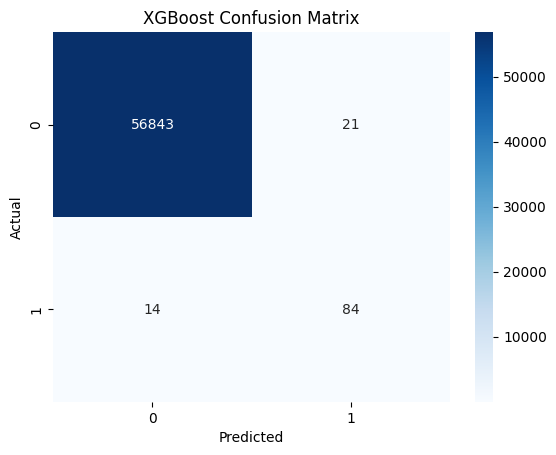

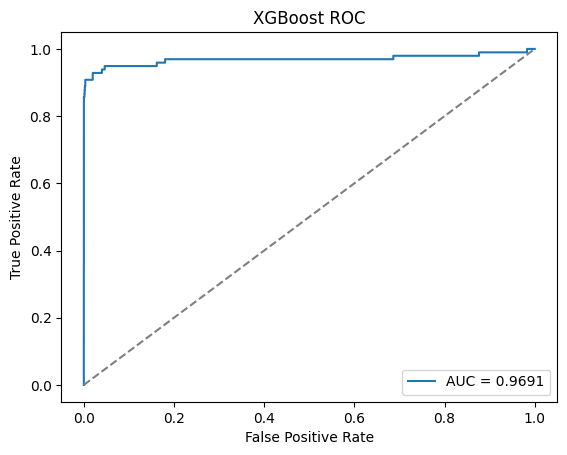


===== Training RandomForest =====
RandomForest optimal threshold: 0.13
              precision    recall  f1-score   support

           0     0.9998    0.9996    0.9997     56864
           1     0.8037    0.8776    0.8390        98

    accuracy                         0.9994     56962
   macro avg     0.9018    0.9386    0.9194     56962
weighted avg     0.9995    0.9994    0.9994     56962

ROC-AUC: 0.9521584977547575


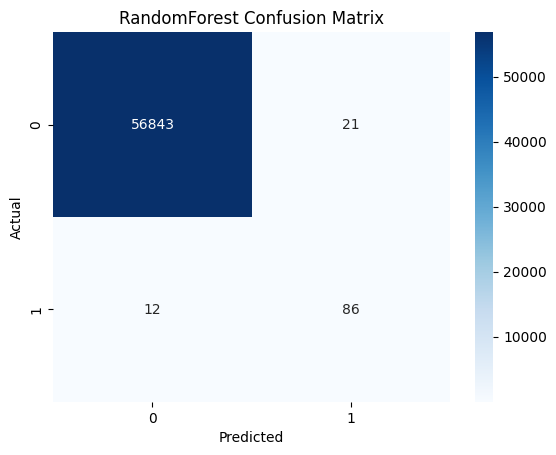

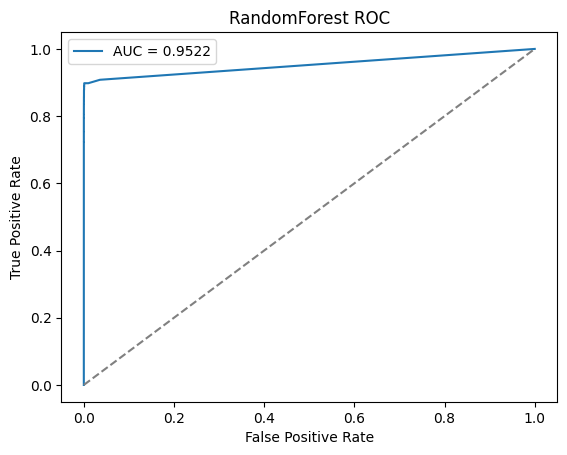


Training complete — both models saved.


In [40]:
# ============================================
# Cell 1: Imports and environment
# ============================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix, auc
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import joblib
import warnings
warnings.filterwarnings('ignore')

# ============================================
# Cell 2: Helper plotting functions
# ============================================
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

def plot_roc(y_true, y_scores, title="ROC Curve"):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    plt.plot(fpr, tpr, label=f"AUC = {auc(fpr,tpr):.4f}")
    plt.plot([0,1],[0,1],'--', color='grey')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend()
    plt.show()

def classification_metrics(y_true, y_pred, y_scores=None):
    print(classification_report(y_true, y_pred, digits=4))
    if y_scores is not None:
        print("ROC-AUC:", roc_auc_score(y_true, y_scores))

# ============================================
# Cell 3: Load dataset via KaggleHub
# ============================================
import kagglehub
import os

path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
print("Dataset downloaded to:", path)
df = pd.read_csv(os.path.join(path, "creditcard.csv"))

# ============================================
# Cell 4: Quick EDA
# ============================================
print(df['Class'].value_counts())
sns.countplot(x='Class', data=df)
plt.show()

sns.histplot(df['Amount'], bins=50, kde=True)
plt.show()

# ============================================
# Cell 5: Feature engineering (Updated: NO HOUR)
# ============================================
df['Amount_log'] = np.log1p(df['Amount'])

df_model = df.drop(['Time','Amount','Hour'], axis=1, errors='ignore')
df_model.head()

# ============================================
# Cell 6: Split and Scale
# ============================================
X = df_model.drop('Class', axis=1)
y = df_model['Class']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, stratify=y, test_size=0.2, random_state=42
)

joblib.dump(scaler, "scaler_creditcard.joblib")

# ============================================
# Cell 7: SMOTE (handle imbalance)
# ============================================
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
print("After SMOTE:", np.bincount(y_train_sm))

# ============================================
# Cell 8: XGBoost / RandomForest Model
# ============================================
desired_precision = 0.8  # threshold target

# -------------------------
# Train XGBoost
# -------------------------
print("\n===== Training XGBoost =====")

xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='auc',
    scale_pos_weight=(y_train==0).sum()/(y_train==1).sum(),
    random_state=42
)

xgb_model.fit(X_train, y_train)
probs_xgb = xgb_model.predict_proba(X_test)[:,1]

precision, recall, thresholds = precision_recall_curve(y_test, probs_xgb)
idx = np.argmax(precision >= desired_precision)
optimal_threshold_xgb = thresholds[idx]

print("XGBoost optimal threshold:", optimal_threshold_xgb)

y_pred_xgb = (probs_xgb >= optimal_threshold_xgb).astype(int)

classification_metrics(y_test, y_pred_xgb, probs_xgb)
plot_confusion_matrix(y_test, y_pred_xgb, "XGBoost Confusion Matrix")
plot_roc(y_test, probs_xgb, "XGBoost ROC")

joblib.dump(xgb_model, "xgb_creditcard.pkl")


# -------------------------
# Train RandomForest
# -------------------------
print("\n===== Training RandomForest =====")

rf_model = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced_subsample',
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
probs_rf = rf_model.predict_proba(X_test)[:,1]

precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test, probs_rf)
idx_rf = np.argmax(precision_rf >= desired_precision)
optimal_threshold_rf = thresholds_rf[idx_rf]

print("RandomForest optimal threshold:", optimal_threshold_rf)

y_pred_rf = (probs_rf >= optimal_threshold_rf).astype(int)

classification_metrics(y_test, y_pred_rf, probs_rf)
plot_confusion_matrix(y_test, y_pred_rf, "RandomForest Confusion Matrix")
plot_roc(y_test, probs_rf, "RandomForest ROC")

joblib.dump(rf_model, "rf_creditcard.pkl")

print("\nTraining complete — both models saved.")

# ============================================
# Cell 9: Preprocess single transaction
# ============================================
def preprocess_transaction(row_dict):
    """
    row_dict: dict {V1..V28, Amount}
    → returns scaled vector for model inference
    """
    tmp = {}
    tmp['Amount_log'] = np.log1p(row_dict['Amount'])
    feat_order = [f'V{i}' for i in range(1,29)] + ['Amount_log']
    arr = np.array([row_dict[f] for f in feat_order], dtype=float).reshape(1, -1)
    arr_scaled = scaler.transform(arr)
    return arr_scaled


Using Colab cache for faster access to the 'credit-card-fraud-detection-dataset-2023' dataset.
Path to dataset files: /kaggle/input/credit-card-fraud-detection-dataset-2023
2023 dataset shape: (568630, 29)
Optimal threshold for ~0.8 precision: 1.9277768e-05
              precision    recall  f1-score   support

           0     0.8583    0.7823    0.8185    284315
           1     0.8000    0.8708    0.8339    284315

    accuracy                         0.8266    568630
   macro avg     0.8291    0.8266    0.8262    568630
weighted avg     0.8291    0.8266    0.8262    568630

ROC-AUC: 0.9135902361505251


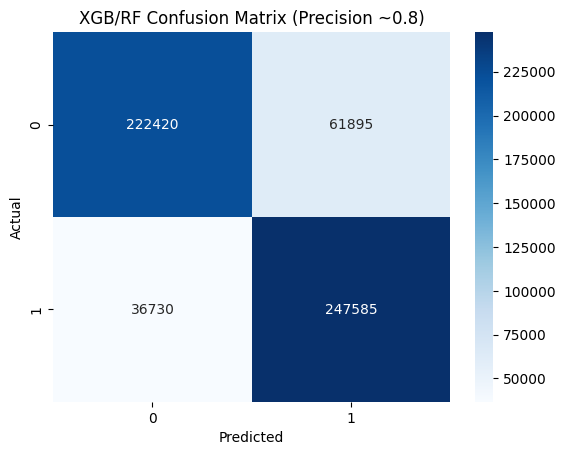

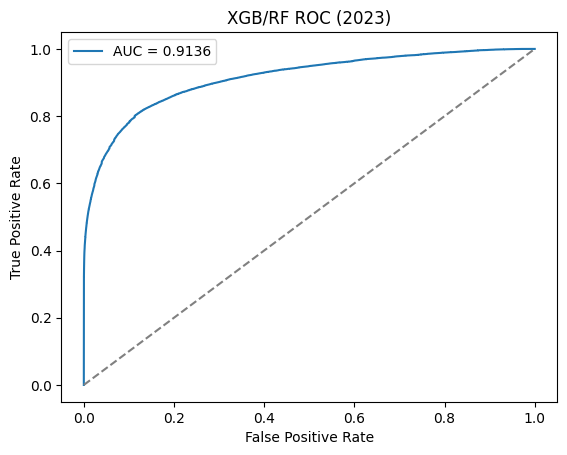

In [43]:
# =======================
# Cell 14: Load 2023 dataset
# =======================
import kagglehub
import os
import joblib

# Download latest version
path_2023 = kagglehub.dataset_download("nelgiriyewithana/credit-card-fraud-detection-dataset-2023")
print("Path to dataset files:", path_2023)

# Load CSV file
csv_files = [f for f in os.listdir(path_2023) if f.endswith('.csv')]
if len(csv_files) == 0:
    raise FileNotFoundError("No CSV file found in the 2023 dataset.")

csv_2023_path = os.path.join(path_2023, csv_files[0])
df_2023 = pd.read_csv(csv_2023_path)
df_2023.head()

# =======================
# Cell 15: Feature engineering
# =======================
df_2023['Amount_log'] = np.log1p(df_2023['Amount'])

# Drop id, original Amount, and Class
X_2023 = df_2023.drop(['id', 'Amount', 'Class'], axis=1)
y_2023 = df_2023['Class']

# Load trained scaler
scaler = joblib.load("scaler_creditcard.joblib")
X_2023_scaled = scaler.transform(X_2023)
print("2023 dataset shape:", X_2023_scaled.shape)

# =======================
# Cell 16: Evaluate XGBoost / RandomForest with tuned threshold
# =======================
from sklearn.metrics import precision_recall_curve

# Choose the model that exists
try:
    probs_2023 = model_xgb.predict_proba(X_2023_scaled)[:,1]
except:
    probs_2023 = rf.predict_proba(X_2023_scaled)[:,1]

# Tune threshold
desired_precision = 0.8
precision, recall, thresholds = precision_recall_curve(y_2023, probs_2023)
idx = np.argmax(precision >= desired_precision)
optimal_threshold = thresholds[idx]
print("Optimal threshold for ~0.8 precision:", optimal_threshold)

# Predict
y_pred_2023 = (probs_2023 >= optimal_threshold).astype(int)

classification_metrics(y_2023, y_pred_2023, probs_2023)
plot_confusion_matrix(y_2023, y_pred_2023, f"XGB/RF Confusion Matrix (Precision ~{desired_precision})")
plot_roc(y_2023, probs_2023, "XGB/RF ROC (2023)")

# =======================
# Cell 17: Updated preprocess_transaction function
# =======================
def preprocess_transaction(row_dict):
    """
    row_dict: dict with keys 'V1'...'V28', 'Amount'
    Returns scaled numpy array for model input
    """
    tmp = {}
    tmp['Amount_log'] = np.log1p(row_dict['Amount'])
    feat_order = [f'V{i}' for i in range(1,29)] + ['Amount_log']
    arr = np.array([row_dict[f] for f in feat_order], dtype=float).reshape(1,-1)
    arr_scaled = scaler.transform(arr)
    return arr_scaled
